In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

2025-01-25 07:12:23.067425: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 07:12:23.067500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 07:12:23.067537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 07:12:23.076597: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!pip install --upgrade matplotlib seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [3]:
train_df = pd.read_csv('../newKDDTrain+.txt', header=None)

columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
train_df.columns = columns

train_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
test_df = pd.read_csv('../newKDDTest+.txt', header=None)

test_columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'class'
]
# Rename the columns of the DataFrame
test_df.columns = columns

test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


In [5]:
kdd_df = pd.concat([train_df, test_df])

In [6]:
kdd_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [7]:
train_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_training-set.csv")

In [8]:
test_df = pd.read_csv("../UNSW-NB15/UNSW_NB15_testing-set.csv")

In [9]:
unsw_df=pd.concat([train_df, test_df], axis=0)

In [10]:
kdd_df.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [11]:
unsw_df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [12]:
kdd_df['service'].value_counts()

http         48191
private      26627
domain_u      9937
smtp          8247
ftp_data      7711
             ...  
tftp_u           4
http_8001        2
aol              2
harvest          2
http_2784        1
Name: service, Length: 70, dtype: int64

In [13]:
# 각 데이터셋의 컬럼 분포(값의 범위) 확인

def dataset_column_distribution(df, dataset_name):
    print(f"\n{dataset_name} Dataset Column Distributions:\n")
    for column in df.columns:
        col_data = df[column]
        if col_data.dtype in ['int64', 'float64']:
            print(f"{column}: Min={col_data.min()}, Max={col_data.max()}, Mean={col_data.mean():.2f}, Std={col_data.std():.2f}")
        else:
            print(f"{column}: Non-numeric column, Unique Values={col_data.nunique()}")

# KDD 데이터셋 컬럼 분포 확인
dataset_column_distribution(kdd_df, "KDD")

# CIC-IDS 데이터셋 컬럼 분포 확인
dataset_column_distribution(unsw_df, "UNSW-NB15")


KDD Dataset Column Distributions:

duration: Min=0, Max=57715, Mean=276.78, Std=2460.68
protocol_type: Non-numeric column, Unique Values=3
service: Non-numeric column, Unique Values=70
flag: Non-numeric column, Unique Values=11
src_bytes: Min=0, Max=1379963888, Mean=40227.95, Std=5409611.60
dst_bytes: Min=0, Max=1309937401, Mean=17088.85, Std=3703524.78
land: Min=0, Max=1, Mean=0.00, Std=0.01
wrong_fragment: Min=0, Max=3, Mean=0.02, Std=0.24
urgent: Min=0, Max=3, Mean=0.00, Std=0.02
hot: Min=0, Max=101, Mean=0.19, Std=2.01
num_failed_logins: Min=0, Max=5, Mean=0.00, Std=0.07
logged_in: Min=0, Max=1, Mean=0.40, Std=0.49
num_compromised: Min=0, Max=7479, Mean=0.26, Std=22.23
root_shell: Min=0, Max=1, Mean=0.00, Std=0.04
su_attempted: Min=0, Max=2, Mean=0.00, Std=0.04
num_root: Min=0, Max=7468, Mean=0.27, Std=22.69
num_file_creations: Min=0, Max=100, Mean=0.01, Std=0.52
num_shells: Min=0, Max=5, Mean=0.00, Std=0.03
num_access_files: Min=0, Max=9, Mean=0.00, Std=0.10
num_outbound_cmds: Mi

In [14]:
kdd_df['protocol_type'].value_counts()

tcp     121569
udp      17614
icmp      9334
Name: protocol_type, dtype: int64

In [15]:
# 매핑된 피처 중 분포가 너무 다르거나 의미가 불명확한 피처 제외
kdd_to_unsw_mapping = {
    # 시간 관련
    "duration": "dur",  # 데이터 전송 시간

    # 프로토콜 관련
    "protocol_type": "proto",  # 프로토콜 (TCP, UDP 등)

    # 서비스 관련
    "service": "service",  # 서비스 종류 (HTTP, FTP 등)

    # 연결 상태 플래그
    "flag": "state",  # 상태 플래그

    # 데이터 크기 관련
    "src_bytes": "sbytes",  # 소스 바이트 크기
    "dst_bytes": "dbytes",  # 목적지 바이트 크기

    # 연결 및 호스트 관련
    "land": "is_sm_ips_ports",  # 동일 호스트/포트 여부
    "wrong_fragment": "trans_depth",  # 전송 깊이(잘못된 프래그먼트 포함 가능)
    "urgent": "ct_ftp_cmd",  # 긴급 플래그(FTP 명령 수와 비슷한 의미)

    # 공격 탐지와 관련된 정보
    "hot": "ct_dst_sport_ltm",  # 연결된 목적지 스포츠 수
    "num_failed_logins": "ct_dst_sport_ltm",  # 실패한 로그인 시도 수
    "logged_in": "is_ftp_login",  # 로그인 성공 여부
    "num_compromised": "num_compromised",  # 손상된 파일 수

    # 루트 사용자 관련
    "root_shell": "root_shell",  # 루트 쉘 여부
    "su_attempted": "su_attempted",  # `su` 명령 시도 여부

    # 명령 및 파일 관련
    "num_root": "num_root",  # 루트 명령 횟수
    "num_file_creations": "ct_flw_http_mthd",  # 파일 생성 수 (HTTP 요청과 유사)
    "num_outbound_cmds": "num_outbound_cmds",  # 외부 명령 수

    # 로그인 여부 관련
    "is_host_login": "is_ftp_login",  # 호스트 로그인 여부
    "is_guest_login": "is_ftp_login",  # 게스트 로그인 여부

    # 연결 및 서버 관련
    "count": "ct_srv_dst",  # 연결 요청 수
    "srv_count": "ct_srv_src",  # 서비스 요청 수

    # 에러 비율 관련
    "serror_rate": "serror_rate",  # 서버 오류 비율
    "srv_serror_rate": "srv_serror_rate",  # 서버 오류 비율 (서비스별)
    "rerror_rate": "rerror_rate",  # 연결 실패 비율
    "srv_rerror_rate": "srv_rerror_rate",  # 연결 실패 비율 (서비스별)
    "same_srv_rate": "same_srv_rate",  # 동일 서버 비율
    "diff_srv_rate": "diff_srv_rate",  # 다른 서버 비율
    "srv_diff_host_rate": "srv_diff_host_rate",  # 다른 호스트로의 요청 비율

    # 목적지 호스트 관련
    "dst_host_count": "ct_dst_ltm",  # 목적지 호스트 수
    "dst_host_srv_count": "ct_srv_dst",  # 목적지 서버 수
    "dst_host_same_srv_rate": "same_srv_rate",  # 동일 서버 비율
    "dst_host_diff_srv_rate": "diff_srv_rate",  # 다른 서버 비율
    "dst_host_same_src_port_rate": "same_srv_rate",  # 동일 소스-포트 비율
    "dst_host_srv_diff_host_rate": "srv_diff_host_rate",  # 다른 호스트 비율
    "dst_host_serror_rate": "serror_rate",  # 서버 오류 비율
    "dst_host_srv_serror_rate": "srv_serror_rate",  # 서버 오류 비율 (서버별)
    "dst_host_rerror_rate": "rerror_rate",  # 연결 실패 비율
    "dst_host_srv_rerror_rate": "srv_rerror_rate",  # 연결 실패 비율 (서버별)

    # 라벨
    "class": "label",  # 공격 여부를 나타내는 클래스
}


def process_datasets(kdd_df, unsw_df, mapping):
    """
    Process datasets to ensure the same columns in both datasets.
    Args:
    - kdd_df: KDD dataset DataFrame.
    - unsw_df: UNSW-NB15 dataset DataFrame.
    - mapping: Dictionary mapping KDD columns to UNSW columns.
    
    Returns:
    - kdd_processed: Processed KDD DataFrame with the same columns as UNSW DataFrame.
    - unsw_processed: Processed UNSW DataFrame with the same columns as KDD DataFrame.
    """
    # 교차검증: 매핑된 컬럼 중 실제 존재하는 컬럼만 사용
    kdd_valid_columns = [col for col in mapping.keys() if col in kdd_df.columns]
    unsw_valid_columns = [mapping[col] for col in kdd_valid_columns if mapping[col] in unsw_df.columns]

    # KDD 데이터셋 필터링 및 컬럼 이름 변경
    kdd_filtered = kdd_df[kdd_valid_columns].copy()
    kdd_filtered.rename(columns={col: mapping[col] for col in kdd_valid_columns}, inplace=True)

    # 중복 제거: 중복된 컬럼은 첫 번째 값만 유지
    kdd_filtered = kdd_filtered.loc[:, ~kdd_filtered.columns.duplicated()]
    unsw_filtered = unsw_df.loc[:, ~unsw_df.columns.duplicated()]

    # 공통 컬럼 집합 만들기
    all_columns = list(set(kdd_filtered.columns).union(set(unsw_filtered.columns)))

    # 누락된 컬럼 추가 및 순서 정렬
    kdd_processed = kdd_filtered.reindex(columns=all_columns, fill_value=0)
    unsw_processed = unsw_filtered.reindex(columns=all_columns, fill_value=0)

    return kdd_processed, unsw_processed


# 데이터셋 처리 및 매핑 적용
try:
    new_kdd_df, new_unsw_df = process_datasets(kdd_df, unsw_df, kdd_to_unsw_mapping)
    print("Processed KDD DataFrame shape:", new_kdd_df.shape)
    print("Processed UNSW DataFrame shape:", new_unsw_df.shape)
except ValueError as e:
    print(f"Error occurred: {e}")

# 컬럼 이름 확인
print("Columns in processed KDD DataFrame:", new_kdd_df.columns.tolist() if 'new_kdd_df' in locals() else "KDD processing failed.")
print("Columns in processed UNSW DataFrame:", new_unsw_df.columns.tolist() if 'new_unsw_df' in locals() else "UNSW processing failed.")

Processed KDD DataFrame shape: (148517, 57)
Processed UNSW DataFrame shape: (257673, 57)
Columns in processed KDD DataFrame: ['ct_src_ltm', 'num_compromised', 'attack_cat', 'su_attempted', 'ct_dst_sport_ltm', 'srv_rerror_rate', 'sjit', 'tcprtt', 'ct_dst_src_ltm', 'dloss', 'rate', 'srv_serror_rate', 'swin', 'proto', 'dttl', 'sinpkt', 'num_root', 'sload', 'rerror_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dload', 'ct_srv_src', 'synack', 'is_ftp_login', 'ct_dst_ltm', 'root_shell', 'state', 'dtcpb', 'ct_ftp_cmd', 'service', 'sloss', 'response_body_len', 'stcpb', 'num_outbound_cmds', 'dbytes', 'sttl', 'djit', 'ackdat', 'smean', 'dpkts', 'ct_srv_dst', 'dinpkt', 'ct_flw_http_mthd', 'sbytes', 'ct_src_dport_ltm', 'same_srv_rate', 'dwin', 'is_sm_ips_ports', 'spkts', 'id', 'serror_rate', 'trans_depth', 'ct_state_ttl', 'label', 'dmean', 'dur']
Columns in processed UNSW DataFrame: ['ct_src_ltm', 'num_compromised', 'attack_cat', 'su_attempted', 'ct_dst_sport_ltm', 'srv_rerror_rate', 'sjit', 'tcp

In [16]:
# 중복된 컬럼 제거
new_kdd_df = new_kdd_df.loc[:, ~new_kdd_df.columns.duplicated()]
new_unsw_df = new_unsw_df.loc[:, ~new_unsw_df.columns.duplicated()]

In [17]:
new_kdd_df

,ct_src_ltm,num_compromised,attack_cat,su_attempted,ct_dst_sport_ltm,srv_rerror_rate,sjit,tcprtt,ct_dst_src_ltm,dloss,...,dwin,is_sm_ips_ports,spkts,id,serror_rate,trans_depth,ct_state_ttl,label,dmean,dur
0,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0.0,0,0,normal,0,0
1,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0.0,0,0,normal,0,0
2,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,1.0,0,0,anomaly,0,0
3,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0.2,0,0,normal,0,0
4,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0.0,0,0,normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0.0,0,0,normal,0,0
22540,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0.0,0,0,normal,0,0
22541,0,1,0,0,2,0.0,0,0,0,0,...,0,0,0,0,0.0,0,0,anomaly,0,0
22542,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0.0,0,0,normal,0,0


In [18]:
new_unsw_df

,ct_src_ltm,num_compromised,attack_cat,su_attempted,ct_dst_sport_ltm,srv_rerror_rate,sjit,tcprtt,ct_dst_src_ltm,dloss,...,dwin,is_sm_ips_ports,spkts,id,serror_rate,trans_depth,ct_state_ttl,label,dmean,dur
0,1,0,Normal,0,1,0,30.177547,0.000000,1,0,...,255,0,6,1,0,0,0,0,43,0.121478
1,1,0,Normal,0,1,0,61.426934,0.000000,2,17,...,255,0,14,2,0,0,1,0,1106,0.649902
2,2,0,Normal,0,1,0,17179.586860,0.111897,3,6,...,255,0,8,3,0,0,1,0,824,1.623129
3,2,0,Normal,0,1,0,259.080172,0.000000,3,3,...,255,0,12,4,0,0,1,0,64,1.681642
4,2,0,Normal,0,1,0,2415.837634,0.128381,40,1,...,255,0,10,5,0,0,1,0,45,0.449454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,2,0,Normal,0,1,0,0.000000,0.000000,2,0,...,0,0,2,82328,0,0,2,0,0,0.000005
82328,3,0,Normal,0,1,0,4798.130981,0.173208,1,1,...,255,0,20,82329,0,0,1,0,44,1.106101
82329,1,0,Normal,0,1,0,0.000000,0.000000,1,0,...,0,1,1,82330,0,0,2,0,0,0.000000
82330,1,0,Normal,0,1,0,10.954518,0.000000,1,0,...,0,1,1,82331,0,0,2,0,0,0.000000


In [19]:
new_kdd_df['label'] = new_kdd_df['label'].apply(lambda x: 0 if x == 'normal' else 1)


In [20]:
new_kdd_df['label'].value_counts()

0    77054
1    71463
Name: label, dtype: int64

In [21]:
new_kdd_df.columns==new_unsw_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [22]:
from sklearn.preprocessing import OrdinalEncoder

# 주요 서비스 설정
major_services = [
    'http', 'dns', 'smtp', 'ftp-data', 'ftp', 'pop3', 'ssh', 'irc'
]

# NSL-KDD 데이터셋 처리
new_kdd_df['service'] = new_kdd_df['service'].apply(lambda x: x if x in major_services else 'others')

# UNSW-NB15 데이터셋 처리
new_unsw_df['service'] = new_unsw_df['service'].apply(lambda x: x if x in major_services else 'others')

# 서비스 컬럼 합치기 (KDD와 UNSW 공통으로 처리하기 위해)
all_services = list(set(new_kdd_df['service'].unique()).union(set(new_unsw_df['service'].unique())))

# OrdinalEncoder 생성 및 적용
encoder = OrdinalEncoder(categories=[all_services])  # 공통된 서비스 순서를 지정
new_kdd_df['service_encoded'] = encoder.fit_transform(new_kdd_df[['service']])
new_unsw_df['service_encoded'] = encoder.transform(new_unsw_df[['service']])

# 기존 service 컬럼 제거 (원본이 필요 없다면)
new_kdd_df = new_kdd_df.drop(columns=['service'])
new_unsw_df = new_unsw_df.drop(columns=['service'])

# 결과 확인
print("Encoded NSL-KDD 데이터셋:")
print(new_kdd_df.head())

print("Encoded UNSW-NB15 데이터셋:")
print(new_unsw_df.head())

Encoded NSL-KDD 데이터셋:
   ct_src_ltm  num_compromised  attack_cat  su_attempted  ct_dst_sport_ltm  \
0           0                0           0             0                 0   
1           0                0           0             0                 0   
2           0                0           0             0                 0   
3           0                0           0             0                 0   
4           0                0           0             0                 0   

   srv_rerror_rate  sjit  tcprtt  ct_dst_src_ltm  dloss  ...  is_sm_ips_ports  \
0              0.0     0       0               0      0  ...                0   
1              0.0     0       0               0      0  ...                0   
2              0.0     0       0               0      0  ...                0   
3              0.0     0       0               0      0  ...                0   
4              0.0     0       0               0      0  ...                0   

   spkts  id serror_ra

In [23]:
print("cicids shape : ",new_unsw_df.shape)
print("kdd shape : ",new_kdd_df.shape)


cicids shape :  (257673, 57)
kdd shape :  (148517, 57)


In [24]:
# 프로토콜 매핑 사전
protocol_map = {
    'tcp': 6,    # TCP
    'udp': 17,   # UDP
    'icmp': 1    # ICMP
}

# 나머지 값은 0으로 처리
new_kdd_df['Protocol_Mapped'] = new_kdd_df['proto'].str.lower().map(protocol_map).fillna(0).astype(int)

new_kdd_df['proto'] = new_kdd_df['Protocol_Mapped']
new_kdd_df = new_kdd_df.drop(labels='Protocol_Mapped', axis=1)

In [25]:
# 프로토콜 매핑 사전
protocol_map = {
    'tcp': 6,    # TCP
    'udp': 17,   # UDP
    'icmp': 1    # ICMP
}

# 나머지 값은 0으로 처리
new_unsw_df['Protocol_Mapped'] = new_unsw_df['proto'].str.lower().map(protocol_map).fillna(0).astype(int)

new_unsw_df['proto'] = new_unsw_df['Protocol_Mapped']
new_unsw_df = new_unsw_df.drop(labels='Protocol_Mapped', axis=1)

In [26]:
new_kdd_df['proto'].value_counts()

6     121569
17     17614
1       9334
Name: proto, dtype: int64

In [27]:
new_kdd_df.shape

(148517, 57)

In [28]:
new_unsw_df.shape

(257673, 57)

In [29]:
from sklearn.preprocessing import OrdinalEncoder

# 통합적 정의 (mapping dictionary)
state_mapping = {
    # 연결 성공
    'FIN': 'connected', 'SF': 'connected', 'CON': 'connected',
    
    # 연결 실패
    'S0': 'failed', 'REJ': 'failed', 'RST': 'failed', 'RSTO': 'failed', 'RSTOS0': 'failed',
    
    # 연결 중단
    'INT': 'interrupted', 'RSTR': 'interrupted', 'SH': 'interrupted',
    
    # 기타
    'REQ': 'other', 'ECO': 'other', 'ACC': 'other', 'PAR': 'other', 'URN': 'other', 
    'no': 'other', 'CLO': 'other', 'S1': 'other', 'S3': 'other', 'S2': 'other', 'OTH': 'other'
}

# 상태 값을 통합적 정의로 변환
new_unsw_df['mapped_state'] = new_unsw_df['state'].map(state_mapping)
new_kdd_df['mapped_state'] = new_kdd_df['state'].map(state_mapping)

# Ordinal Encoding 준비
all_states = ['connected', 'failed', 'interrupted', 'other']  # 모든 상태 정의

# OrdinalEncoder 생성
encoder = OrdinalEncoder(categories=[all_states])

# Ordinal Encoding 적용
new_unsw_df['state_encoded'] = encoder.fit_transform(new_unsw_df[['mapped_state']])
new_kdd_df['state_encoded'] = encoder.transform(new_kdd_df[['mapped_state']])

# 기존 mapped_state 컬럼 삭제 (필요시)
new_unsw_df = new_unsw_df.drop(columns=['mapped_state'])
new_kdd_df = new_kdd_df.drop(columns=['mapped_state'])

# 결과 확인
print("UNSW 데이터셋 (Ordinal Encoding):")
print(new_unsw_df[['state', 'state_encoded']].head())

print("\nKDD 데이터셋 (Ordinal Encoding):")
print(new_kdd_df[['state', 'state_encoded']].head())

UNSW 데이터셋 (Ordinal Encoding):
  state  state_encoded
0   FIN            0.0
1   FIN            0.0
2   FIN            0.0
3   FIN            0.0
4   FIN            0.0

KDD 데이터셋 (Ordinal Encoding):
  state  state_encoded
0    SF            0.0
1    SF            0.0
2    S0            1.0
3    SF            0.0
4    SF            0.0


In [30]:
# object 타입 컬럼만 선택
object_columns = new_unsw_df.columns[new_unsw_df.dtypes == 'object']

print("Object 타입 컬럼:", object_columns.tolist())

Object 타입 컬럼: ['attack_cat', 'state']


In [31]:
new_kdd_df= new_kdd_df.drop(labels='state', axis=1)
new_unsw_df= new_unsw_df.drop(labels='state', axis=1)

In [32]:
new_kdd_df= new_kdd_df.drop(labels='attack_cat', axis=1)
new_unsw_df= new_unsw_df.drop(labels='attack_cat', axis=1)

In [33]:
new_kdd_df.shape

(148517, 56)

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# CIC-IDS 데이터셋 PCA 적용
def apply_pca(df, n_components=2):
    scaler = StandardScaler()
    features = df.drop(columns=['label'])  # 라벨 제외
    labels = df['label']
    
    # 정규화
    features_scaled = scaler.fit_transform(features)
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(features_scaled)
    
    # PCA 결과 데이터프레임 생성
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df['label'] = labels.reset_index(drop=True)
    
    # 주성분 설명력
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio for {n_components} components: {explained_variance}")
    
    return pca_df, explained_variance


print("unsw-df PCA 적용")
unsw_pca_df, unsw_variance = apply_pca(new_unsw_df, n_components=20)

print("NSL-KDD PCA 적용")
kdd_pca_df, kdd_variance = apply_pca(new_kdd_df, n_components=20)

# 결과 출력
print("CIC-IDS PCA 데이터셋")
print(unsw_pca_df.head())

print("KDD PCA 데이터셋")
print(kdd_pca_df.head())


unsw-df PCA 적용
Explained variance ratio for 20 components: [0.26106198 0.09063309 0.0858707  0.07134479 0.05913901 0.05007521
 0.04644241 0.04410776 0.02874905 0.02754377 0.0258761  0.02227262
 0.01929171 0.01784653 0.01746338 0.01701203 0.01584252 0.01364871
 0.01067297 0.00896547]
NSL-KDD PCA 적용
Explained variance ratio for 20 components: [0.18530134 0.09819443 0.09424889 0.073316   0.04843102 0.04544103
 0.04306221 0.04231515 0.03906934 0.03846223 0.03770373 0.03637874
 0.03542596 0.03456079 0.03172381 0.02922024 0.0259131  0.01819011
 0.01637773 0.01143118]
CIC-IDS PCA 데이터셋
        PC1       PC2       PC3       PC4       PC5       PC6        PC7  \
0  2.542354 -0.546802  0.261991 -0.586460 -0.717113 -0.462671  -0.099647   
1  2.454612  1.833231  0.264496 -1.910265 -1.155582  0.010278  -0.696458   
2  3.734913  0.922523 -0.852263 -1.104934 -0.271235  0.944359  -0.696716   
3  2.933705  0.006015 -0.313637 -1.237934 -2.009002  3.644299  11.249352   
4  0.462366  1.154274 -3.019442 -0.

In [35]:
unsw_pca_df.shape

(257673, 21)

In [36]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

Defaulting to user installation because normal site-packages is not writeable


In [37]:
!python -c "import sklearn; print(sklearn.__version__)"
!python -c "import imblearn; print(imblearn.__version__)"

1.2.2
0.10.1


In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm


# 1. GAN Generator Block
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )


# 2. GAN Discriminator Block
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True),
    )


# 3. GAN Generator
class Generator(nn.Module):
    def __init__(self, z_dim, im_dim, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            nn.Linear(hidden_dim * 4, im_dim),
            nn.Sigmoid(),
        )

    def forward(self, noise):
        return self.gen(noise)


# 4. GAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, im_dim, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 2),
            nn.Linear(hidden_dim * 2, 1),
        )

    def forward(self, image):
        return self.disc(image)


# 5. GAN Training Functions
def train_gan(
    generator,
    discriminator,
    data_loader,
    z_dim,
    num_epochs,
    device="cuda",
    lr=0.0001,
):
    criterion = nn.BCEWithLogitsLoss()
    gen_opt = torch.optim.Adam(generator.parameters(), lr=lr)
    disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for real, _ in tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            real = real.to(device)
            cur_batch_size = len(real)
            noise = torch.randn(cur_batch_size, z_dim).to(device)

            # Train Discriminator
            disc_opt.zero_grad()
            fake = generator(noise)
            fake_pred = discriminator(fake.detach())
            real_pred = discriminator(real)
            
            disc_loss = (
                criterion(fake_pred, torch.zeros_like(fake_pred))  # Fake labels
                + criterion(real_pred, torch.ones_like(real_pred))  # Real labels
            ) / 2
            disc_loss.backward()
            disc_opt.step()

            # Train Generator
            gen_opt.zero_grad()
            fake_pred = discriminator(generator(noise))
            gen_loss = criterion(fake_pred, torch.ones_like(fake_pred))  # Generator tries to fool discriminator
            gen_loss.backward()
            gen_opt.step()

    return generator


def augment_data(X_train, y_train, num_features, smote=True, gan=True, smote_strategy=1.0, gan_multiplier=3):
    augmented_data = []
    augmented_labels = []

    # SMOTE
    if smote:
        sm = SMOTE(sampling_strategy=smote_strategy, random_state=42)
        X_smote, y_smote = sm.fit_resample(X_train, y_train)
        print(f"SMOTE: data shape = {X_smote.shape}, labels shape = {y_smote.shape}")
        augmented_data.append(X_smote)
        augmented_labels.append(y_smote)

    # GAN
    if gan:
        z_dim = num_features
        batch_size = 128
        num_epochs = 10
        device = "cuda" if torch.cuda.is_available() else "cpu"

        generator = Generator(z_dim=z_dim, im_dim=num_features).to(device)
        discriminator = Discriminator(im_dim=num_features).to(device)

        X_torch = torch.tensor(X_train, dtype=torch.float32)
        y_torch = torch.tensor(y_train, dtype=torch.float32)
        dataset = TensorDataset(X_torch, y_torch)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        generator = train_gan(
            generator, discriminator, data_loader, z_dim, num_epochs, device=device
        )

        # Generate GAN data
        total_gan_samples = len(X_train) * gan_multiplier
        noise = torch.randn(total_gan_samples, z_dim).to(device)
        X_gan = generator(noise).detach().cpu().numpy()
        y_gan = np.random.choice(np.unique(y_train), len(X_gan))
        print(f"GAN: data shape = {X_gan.shape}, labels shape = {y_gan.shape}")

        augmented_data.append(X_gan)
        augmented_labels.append(y_gan)

    # Combine and return
    print(f"Before merge: {[d.shape for d in augmented_data]}")

    final_data = np.vstack(augmented_data)
    final_labels = np.hstack(augmented_labels)
    print(f"Final: data shape = {final_data.shape}, labels shape = {final_labels.shape}")

    # Ensure lengths match
    if len(final_data) != len(final_labels):
        print(f"Mismatch detected: final_data = {len(final_data)}, final_labels = {len(final_labels)}")
        min_length = min(len(final_data), len(final_labels))
        final_data = final_data[:min_length]
        final_labels = final_labels[:min_length]

    return final_data, final_labels


# 메인 코드
if __name__ == "__main__":
    # Extract features and labels
    X = kdd_pca_df.iloc[:, :-1].values
    y = kdd_pca_df.iloc[:, -1].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Data augmentation
    final_data, final_labels = augment_data(
        X_train, 
        y_train, 
        num_features=X_train.shape[1], 
        smote_strategy=1.0,  # SMOTE 증대 비율 조정
        gan_multiplier=3    # GAN 증대 배수 조정
    )

    # Save augmented data
    kdd_augmented_df = pd.DataFrame(final_data, columns=[f"feature_{i}" for i in range(final_data.shape[1])])
    kdd_augmented_df["label"] = final_labels

    print(kdd_augmented_df.head())



SMOTE: data shape = (123208, 20), labels shape = (123208,)


Epoch 1/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/929 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/929 [00:00<?, ?it/s]

GAN: data shape = (356439, 20), labels shape = (356439,)
Before merge: [(123208, 20), (356439, 20)]
Final: data shape = (479647, 20), labels shape = (479647,)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   3.057250  -0.233832  -0.091567  -1.306486   0.221890  -0.242858   
1   2.288769  -0.177461  -0.034907  -0.561369   0.037318   0.008202   
2   2.599932  -0.309212  -0.088479  -0.934580   0.073365  -0.126706   
3  -3.087615  -1.604686   0.254518  -0.593722  -0.004755  -0.022438   
4  -3.137401  -1.594541   0.252762  -0.585398   0.013096  -0.053424   

   feature_6  feature_7  feature_8  feature_9  ...  feature_11  feature_12  \
0   0.585366  -0.285026  -0.402536  -0.007695  ...   -0.490423    0.027144   
1  -0.020325   0.016163  -0.230776   0.001561  ...   -0.217848    0.035548   
2   0.953843  -0.503904  -0.539325   0.001672  ...   -0.808587   -0.023510   
3   0.026149   0.061157  -0.033740  -0.001222  ...    0.061279    0.031217   
4   0.038499   0.036321 

In [39]:
kdd_pca_df.shape

(148517, 21)

In [40]:
kdd_augmented_df.shape

(479647, 21)

In [41]:
X_train_normal = kdd_augmented_df[kdd_augmented_df['label'] == 0]


In [42]:
X_train_normal.shape

(240087, 21)

In [43]:
X_test = unsw_pca_df

In [44]:
y_train_normal = X_train_normal['label']
X_train_normal= X_train_normal.drop(labels='label', axis=1)

y_test = X_test['label']
X_test= X_test.drop(labels='label', axis=1)

In [45]:
X_train_normal

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,3.057250,-0.233832,-0.091567,-1.306486e+00,2.218902e-01,-0.242858,5.853665e-01,-2.850259e-01,-4.025356e-01,-0.007695,1.934042e-01,-4.904234e-01,2.714449e-02,-1.315617e-01,8.946897e-01,-1.170899,4.892655e-01,1.908410e+00,4.187737e-02,9.933014e-02
1,2.288769,-0.177461,-0.034907,-5.613688e-01,3.731828e-02,0.008202,-2.032460e-02,1.616254e-02,-2.307759e-01,0.001561,-1.013990e-01,-2.178484e-01,3.554829e-02,1.352797e-01,5.326868e-01,0.531811,-7.472954e-01,6.157567e-01,-3.514026e-02,2.483603e-01
2,2.599932,-0.309212,-0.088479,-9.345798e-01,7.336519e-02,-0.126706,9.538434e-01,-5.039035e-01,-5.393255e-01,0.001672,2.974921e-01,-8.085871e-01,-2.351006e-02,3.154960e-02,9.788321e-01,-1.773248,1.141099e+00,7.840653e-01,3.990716e-02,-1.549853e-01
6,2.940677,-0.010720,-0.130661,-1.302869e+00,8.304683e-01,-0.440541,-1.299391e+00,4.828257e-01,6.631475e-01,-0.022821,-2.965485e-02,1.564650e+00,-1.761880e-01,-3.010535e-01,-1.326288e+00,-0.281404,4.244909e-01,-2.455778e-01,1.135290e-02,5.128135e-01
7,1.712460,-0.277793,-0.033837,-1.439727e-02,-1.064112e-01,0.060776,4.447152e-01,-1.876597e-01,-3.835967e-01,0.011867,2.256708e-02,-5.854216e-01,-1.965633e-02,2.953504e-01,6.379615e-01,-0.228805,1.306899e-02,-6.894352e-01,-3.490681e-02,-6.259638e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479639,0.972448,0.012910,0.011662,3.831910e-04,1.930953e-01,0.011927,1.447345e-03,5.487002e-03,1.632662e-03,0.005317,3.429883e-03,1.296800e-04,4.215912e-03,1.153464e-02,4.066882e-03,0.027860,4.062955e-03,1.135588e-02,3.427560e-03,3.946752e-03
479640,0.995716,0.055038,0.880213,4.483067e-14,7.582689e-07,0.000048,1.924145e-08,1.040764e-07,7.194147e-09,0.003591,6.336956e-09,1.530249e-15,1.614860e-11,2.073336e-10,1.434916e-12,0.000004,1.448295e-07,5.440411e-09,3.991773e-11,2.473545e-09
479643,0.981412,0.017503,0.006159,1.728662e-02,1.880294e-01,0.006931,6.413981e-03,8.283552e-03,1.534826e-03,0.007938,3.253076e-03,9.750759e-04,6.211860e-03,8.586245e-03,5.502705e-03,0.013377,3.396340e-02,6.587322e-03,6.316259e-03,3.506858e-03
479644,0.951040,0.435876,0.801272,6.888534e-05,1.530584e-02,0.061164,3.208707e-03,1.194709e-02,7.572082e-02,0.093681,1.585703e-01,1.395311e-03,8.764730e-03,3.612386e-03,1.405815e-03,0.247589,4.956290e-02,4.326567e-04,1.397396e-01,9.897064e-03


In [46]:
X_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,2.542354,-0.546802,0.261991,-0.586460,-0.717113,-0.462671,-0.099647,0.282556,-0.143769,-0.533068,0.056059,-0.697861,-1.263503,0.731074,0.063075,-0.541536,0.335053,-0.847527,-0.352466,0.076438
1,2.454612,1.833231,0.264496,-1.910265,-1.155582,0.010278,-0.696458,0.087463,-0.588112,0.559393,0.952728,-0.007786,0.174988,-0.003827,-0.012928,-0.302953,0.751321,-0.053647,-1.346449,-1.442711
2,3.734913,0.922523,-0.852263,-1.104934,-0.271235,0.944359,-0.696716,0.786707,-0.463055,0.284839,0.374082,0.568233,0.869943,-0.116647,-0.081828,-0.575633,2.524140,0.357073,-0.563412,-0.262240
3,2.933705,0.006015,-0.313637,-1.237934,-2.009002,3.644299,11.249352,0.584970,0.402503,0.346336,0.243933,-0.246062,0.132602,0.780664,0.056999,-0.384145,0.098923,0.286330,-0.512203,0.134473
4,0.462366,1.154274,-3.019442,-0.550258,-0.220126,-0.215990,-0.530188,-0.566934,-1.291768,0.570965,0.621397,-0.647217,-0.237240,1.784358,0.322303,-0.853314,0.147672,-0.060404,-2.881436,-2.287150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,-1.034537,-1.668102,1.767963,0.611517,0.594540,-0.617320,0.289024,0.631444,0.158678,-0.772777,-0.253987,0.670091,-0.150390,-0.208342,0.044515,0.077977,0.003268,-0.032249,-0.435619,0.057420
257669,3.355832,-0.580461,-2.032072,1.372398,0.507687,-0.973822,-0.204549,-0.190469,-0.358406,1.138672,-1.283780,-2.136266,0.009714,-0.351604,0.143055,0.404265,-0.403274,1.226493,0.322051,0.860878
257670,0.161202,-3.137042,4.742194,0.787677,1.184994,7.179745,-1.757415,-7.881547,0.059851,2.023513,-1.058408,0.310818,-0.542905,-0.063848,0.079445,-0.111510,0.275710,-0.015824,-0.503853,0.234491
257671,0.161208,-3.137042,4.742171,0.787688,1.185021,7.179837,-1.757445,-7.881458,0.059839,2.023518,-1.058421,0.310833,-0.542937,-0.063852,0.079451,-0.111496,0.275674,-0.015813,-0.503866,0.234504


In [47]:
y_test

0         0
1         0
2         0
3         0
4         0
         ..
257668    0
257669    0
257670    0
257671    0
257672    0
Name: label, Length: 257673, dtype: int64

In [48]:
!pip install keras_self_attention

Defaulting to user installation because normal site-packages is not writeable


In [49]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# Create CVAE model
model = cvae(X_train_normal, y_train_normal)
model.summary()

from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Compile and train the model with early stopping
history = model.fit([X_train_normal, y_train_normal], X_train_normal,
                    shuffle=True,
                    epochs=50, 
                    validation_split=0.1,  
                    batch_size=32,
                    callbacks=[early_stopping]).history

2025-01-25 07:14:01.682329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 36042 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:cd:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLabel (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 20)                40        ['InputLabel[0][0]']          
                                                                                                  
 InputFeatures (InputLayer)  [(None, 20)]                 0         []                            
                                                                                                  
 flatten (Flatten)           (None, 20)                   0         ['embedding[0][0]']           
                                                                                              

                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None,)                      0         ['tf.math.multiply[0][0]']    
 mbda)                                                                                            
                                                                                                  
 tf.__operators__.add_1 (TF  (None,)                      0         ['tf.math.reduce_sum[0][0]',  
 OpLambda)                                                           'tf.math.multiply_1[0][0]']  
                                                                                                  
 tf.math.reduce_mean (TFOpL  ()                           0         ['tf.__operators__.add_1[0][0]
 ambda)                                                             ']                            
                                                                                                  
 add_loss 

2025-01-25 07:14:03.886636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-25 07:14:04.526955: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f682011f9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-25 07:14:04.527001: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2025-01-25 07:14:04.531646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-25 07:14:04.610212: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6753/6753 [==============================] - 45s 6ms/step - loss: 4629449.0000 - accuracy: 0.9262 - val_loss: 0.0372 - val_accuracy: 0.9354
Epoch 2/50
6753/6753 [==============================] - 41s 6ms/step - loss: 5553362.0000 - accuracy: 0.9393 - val_loss: 0.0890 - val_accuracy: 0.9121
Epoch 3/50
6753/6753 [==============================] - 41s 6ms/step - loss: 1.4289 - accuracy: 0.9454 - val_loss: 0.0183 - val_accuracy: 0.9376
Epoch 4/50
6753/6753 [==============================] - 41s 6ms/step - loss: 0.6231 - accuracy: 0.9484 - val_loss: 0.0173 - val_accuracy: 0.9451
Epoch 5/50
6753/6753 [==============================] - 41s 6ms/step - loss: 0.7516 - accuracy: 0.9499 - val_loss: 0.0146 - val_accuracy: 0.9360
Epoch 6/50
6753/6753 [==============================] - 41s 6ms/step - loss: 0.3903 - accuracy: 0.9542 - val_loss: 0.0211 - val_accuracy: 0.9402
Epoch 7/50
6753/6753 [==============================] - 41s 6ms/step - loss: 163.1093 - accuracy: 0.9499 - val_loss: 0.0258 - val

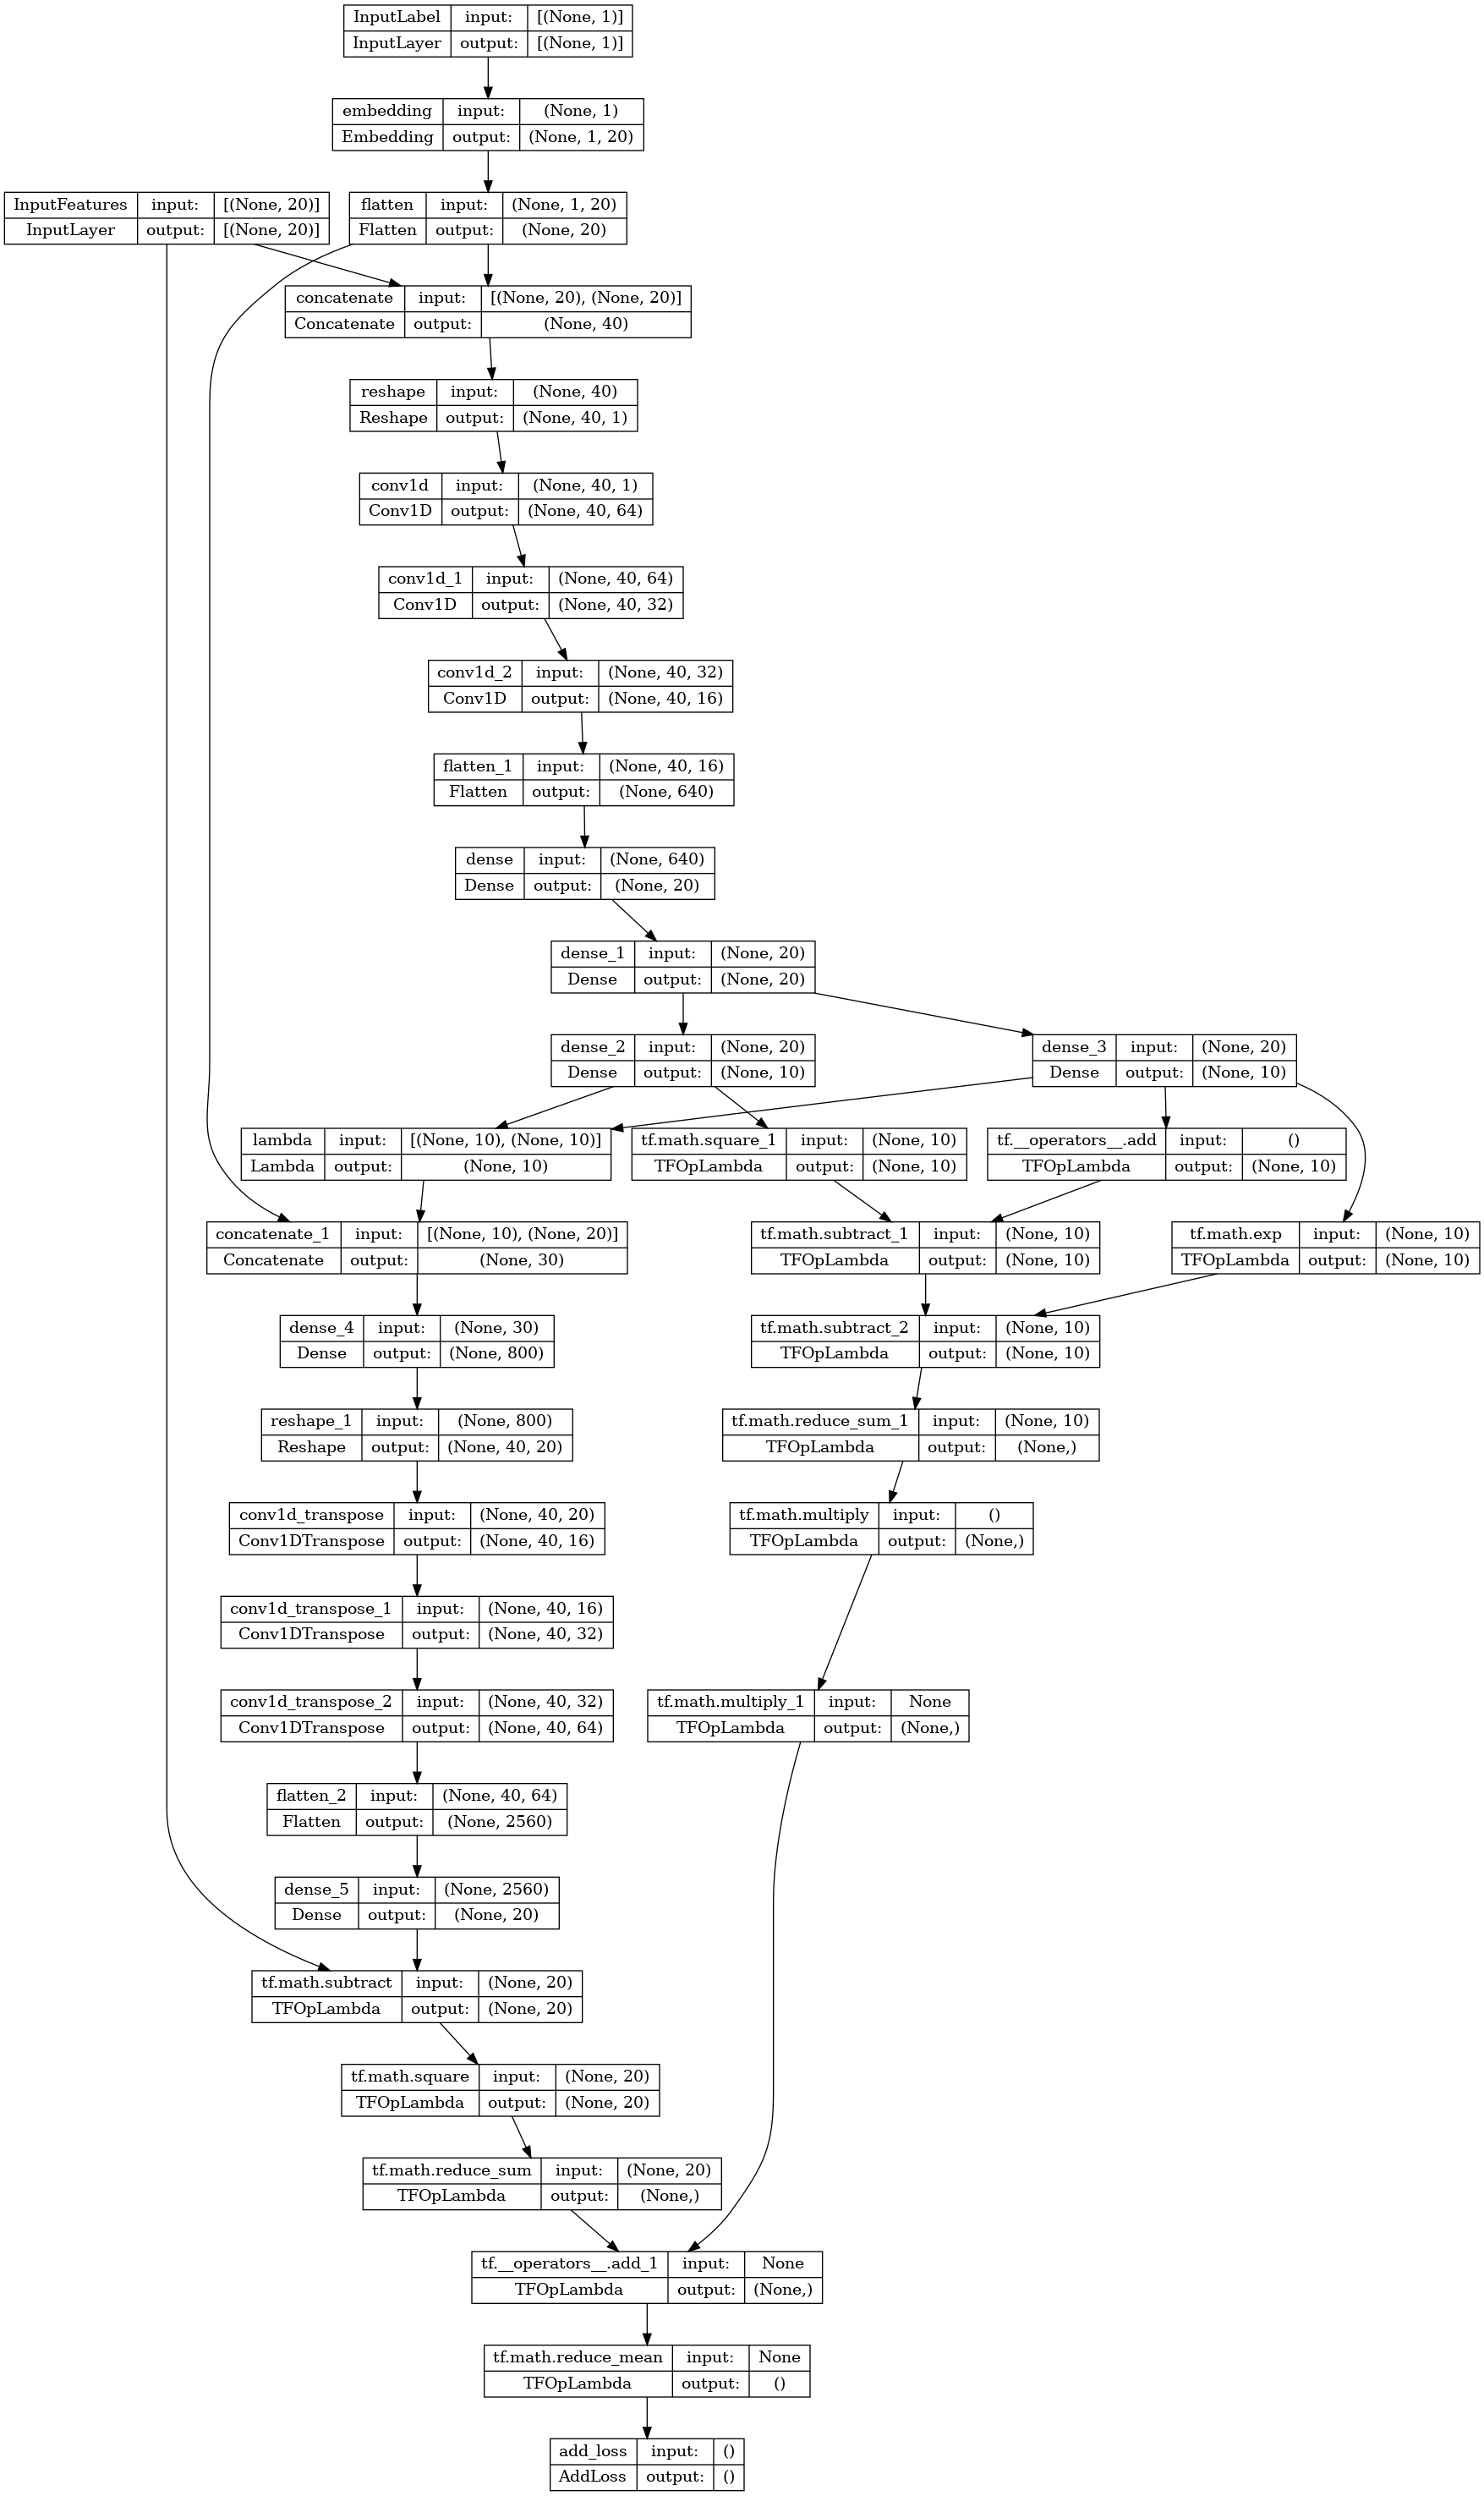

In [51]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_shapes.png', show_shapes=True)

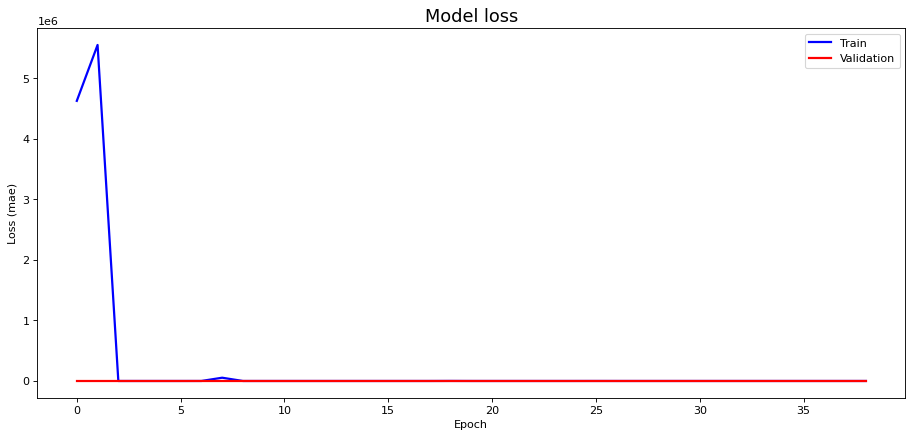

In [52]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [53]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [54]:
valid_x_predictions = model.predict([X_test, y_test])
#mse = np.mean(np.power(flatten(test_X_selected) - flatten(valid_x_predictions), 2), axis=1)

mse = np.mean(np.power(X_test - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.tolist()})

8053/8053 [==============================] - 15s 2ms/step


In [55]:
error_df

,reconstruction_error,true_class
0,0.296180,0
1,0.737781,0
2,0.853070,0
3,2.666823,0
4,2.296761,0
...,...,...
257668,0.549096,0
257669,1.320545,0
257670,6.708476,0
257671,6.955417,0


In [56]:
error_df[error_df['true_class']==0]

,reconstruction_error,true_class
0,0.296180,0
1,0.737781,0
2,0.853070,0
3,2.666823,0
4,2.296761,0
...,...,...
257668,0.549096,0
257669,1.320545,0
257670,6.708476,0
257671,6.955417,0


/tmp/ipykernel_1335/349485020.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


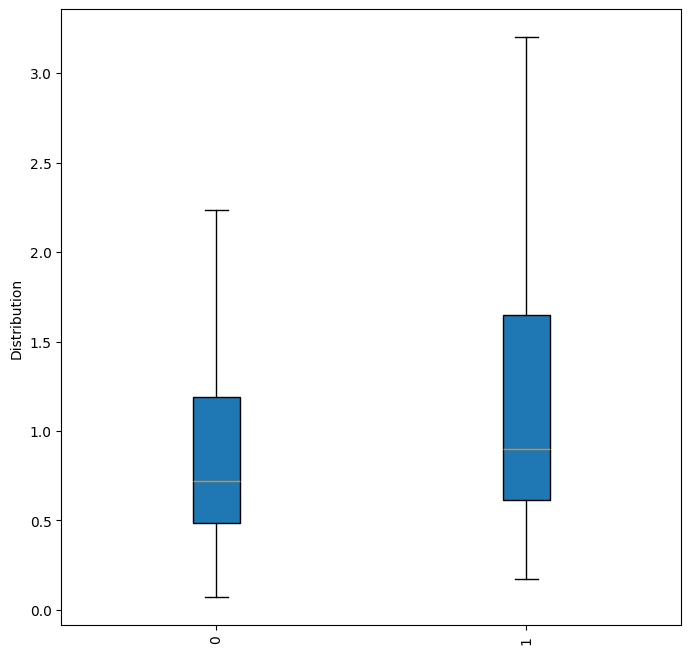

In [57]:
import matplotlib.pyplot as plt

# 데이터프레임 준비
true_class = error_df['true_class'].astype(str)
reconstruction_error = error_df['reconstruction_error']

# 박스 플롯 그리기
plt.figure(figsize=(8, 8))
plt.boxplot(
    [reconstruction_error[true_class == cls] for cls in sorted(true_class.unique())],
    labels=sorted(true_class.unique()),
    showfliers=False,
    vert=True,
    patch_artist=True
)

plt.ylabel('Distribution')
plt.xticks(rotation=90)
plt.show()


Best threshold: 0.45
Best F1 score: 0.8100633263691799


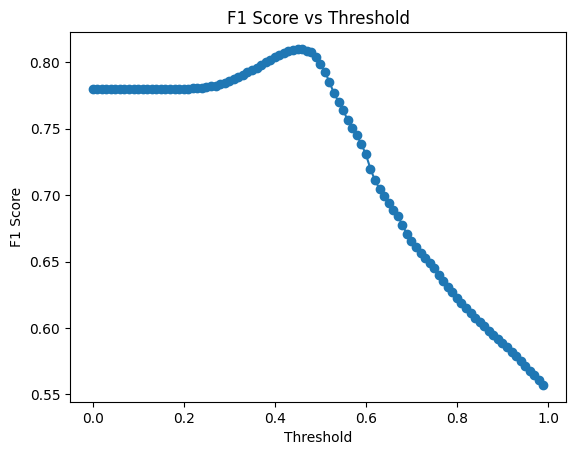

In [58]:


import numpy as np
from sklearn.metrics import f1_score

# Define the range of threshold values
threshold_range = np.arange(0, 1, 0.01)

# List to store F1 scores for each threshold
f1_scores = []

# Loop through each threshold and calculate F1 score
for threshold in threshold_range:
    y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
    f1 = f1_score(error_df.true_class, y_pred)
    f1_scores.append(f1)

# Find the threshold with the highest F1 score
best_threshold = threshold_range[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f"Best threshold: {best_threshold}")
print(f"Best F1 score: {best_f1_score}")

# Optionally, you can plot the F1 scores across the threshold range
plt.plot(threshold_range, f1_scores, marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()


In [70]:
# 그래프 보고 threshold 결정 0.35
threshold = best_threshold
print(threshold)

0.45


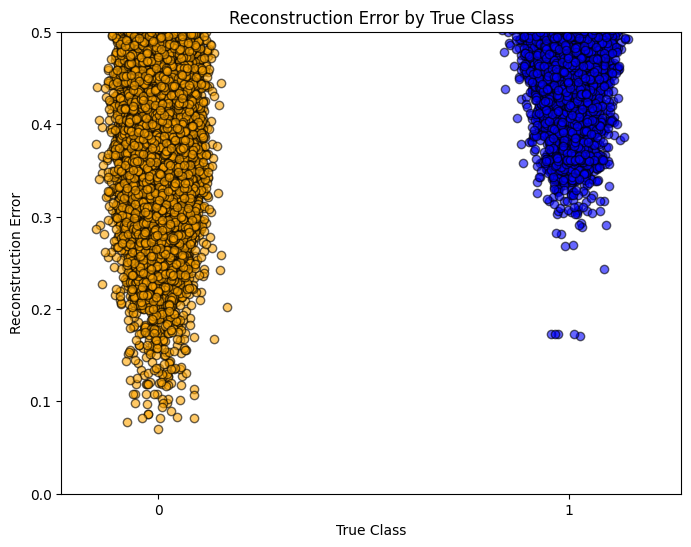

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes with a specified y-axis limit
plt.figure(figsize=(8, 6))

# Add jitter to avoid overlapping points in the scatter plot
x_0 = np.random.normal(1, 0.04, size=len(true_class_0))  # Jitter for class 0
x_1 = np.random.normal(2, 0.04, size=len(true_class_1))  # Jitter for class 1

# Create the scatter plot
plt.scatter(x_0, true_class_0, color='orange', alpha=0.6, edgecolor='black', label='Class 0')
plt.scatter(x_1, true_class_1, color='blue', alpha=0.6, edgecolor='black', label='Class 1')

# Set y-axis limit
plt.ylim(0, 0.5)

# Set x-axis labels and adjust ticks
plt.xticks([1, 2], ['0', '1'])
plt.xlabel('True Class')

# Set y-axis label and title
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by True Class')

# Display the plot
plt.show()


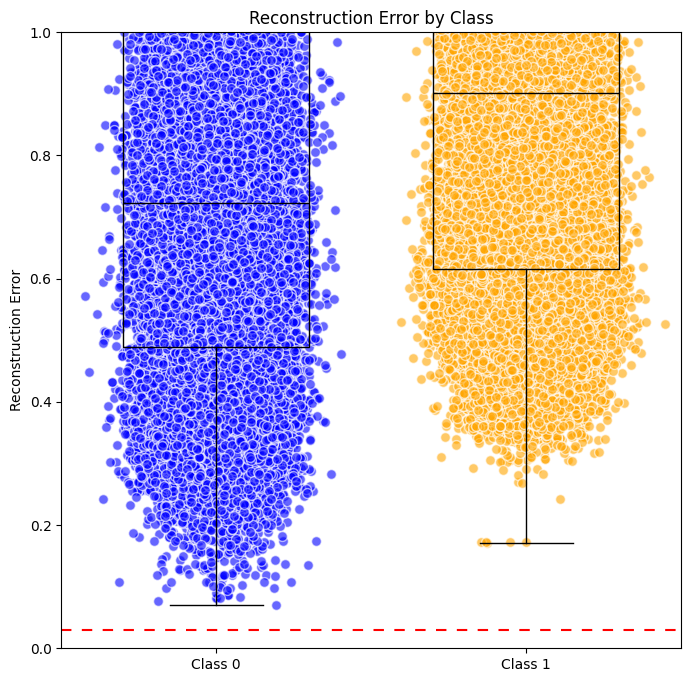

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for plotting
true_class_0 = error_df[error_df['true_class'] == 0]['reconstruction_error']
true_class_1 = error_df[error_df['true_class'] == 1]['reconstruction_error']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Create a swarm plot equivalent using scatter plot with more jitter
x_0 = np.random.normal(1, 0.1, size=len(true_class_0))  # Increased jitter for class 0
x_1 = np.random.normal(2, 0.1, size=len(true_class_1))  # Increased jitter for class 1

ax.scatter(x_0, true_class_0, color='blue', alpha=0.6, label='Class 0', edgecolor='w', s=50)
ax.scatter(x_1, true_class_1, color='orange', alpha=0.6, label='Class 1', edgecolor='w', s=50)

# Create boxplots
ax.boxplot([true_class_0, true_class_1], positions=[1, 2], widths=0.6, patch_artist=True, 
           showfliers=False, boxprops=dict(facecolor='None', color='black'),
           medianprops=dict(color='black'), whiskerprops=dict(color='black'))

# Set x-axis labels
ax.set_xticks([1, 2])
ax.set_xticklabels(['Class 0', 'Class 1'])

# Add a horizontal line at the threshold
ax.axhline(y=0.03, xmin=0.0, xmax=1, dashes=(5, 5), color='red')

# Adjust y-axis limit to make sure the threshold line is visible
#ax.set_ylim(bottom=min(min(true_class_0), min(true_class_1)) - 0.01, 
#           top=max(max(true_class_0), max(true_class_1)) + 0.01)
ax.set_ylim(bottom=0, top=1)
    
# Set labels and title
ax.set_ylabel('Reconstruction Error')
ax.set_title('Reconstruction Error by Class')

plt.show()


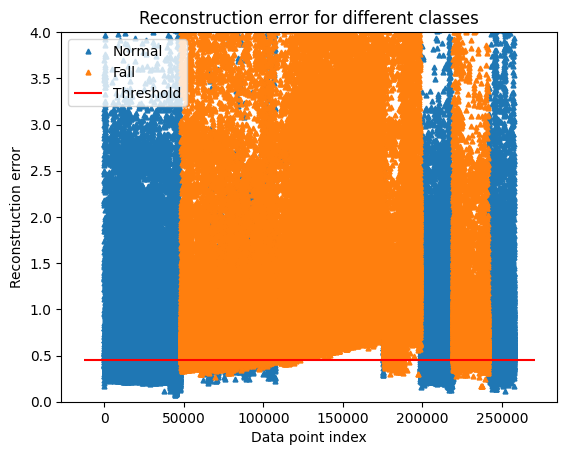

In [62]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label= "Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim(0, 4)
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

<Figure size 1200x1200 with 0 Axes>

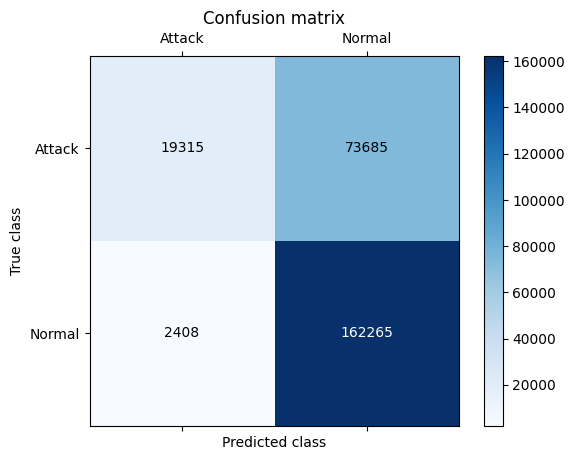

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming you have already defined LABELS, threshold, and y_pred

LABELS = ["Attack", "Normal"]

y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

# Create the figure and axis
plt.figure(figsize=(12, 12))
fig, ax = plt.subplots()

# Plot the confusion matrix using imshow
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

# Add color bar
plt.colorbar(cax)

# Set the labels for the axes
ax.set_xticks(np.arange(len(LABELS)))
ax.set_yticks(np.arange(len(LABELS)))

ax.set_xticklabels(LABELS)
ax.set_yticklabels(LABELS)

# Set labels and title
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix')

# Annotate the confusion matrix with the counts
for i in range(len(LABELS)):
    for j in range(len(LABELS)):
        ax.text(j, i, format(conf_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()


In [64]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.7046916052516173
Precision : 0.6877092604365331
Recall : 0.985377080638599
F1 : 0.8100633263691799


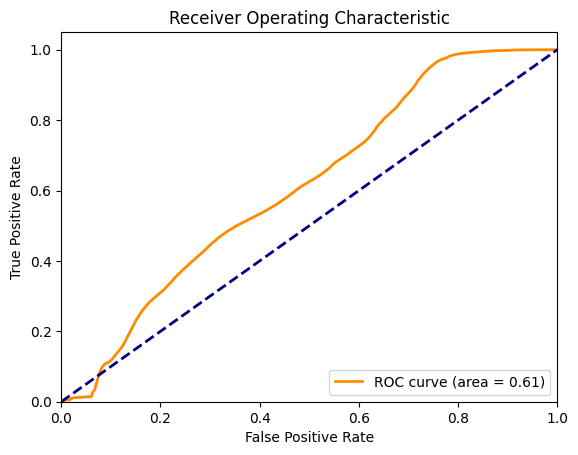

In [65]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and reconstruction_error have been defined
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


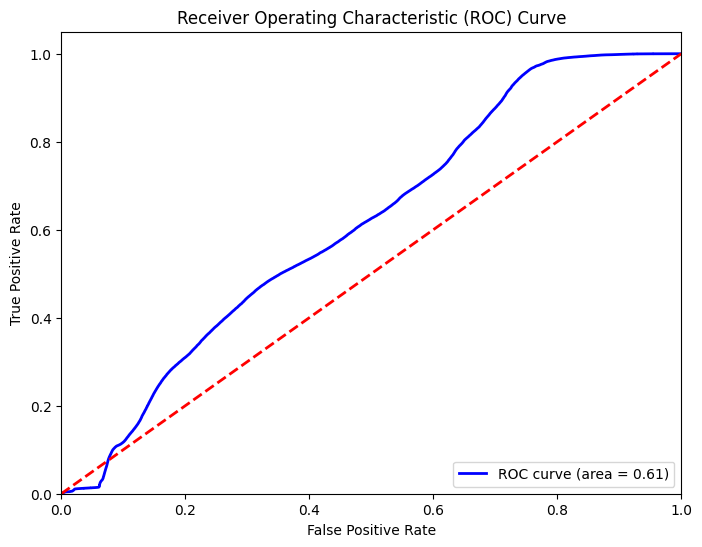

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the true labels and reconstruction errors from error_df
y_true = error_df['true_class']
y_scores = error_df['reconstruction_error']

# Compute the False Positive Rate (FPR) and True Positive Rate (TPR) for different thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

# Set plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Display the plot
plt.show()


In [67]:
print(f"ROC Score : {roc_auc}")

ROC Score : 0.6126270362854662


In [68]:
# If error_df.true_class is a nested structure, flatten it
y_test = error_df.true_class.apply(lambda x: int(x[0][0]) if isinstance(x, list) else int(x))

# Ensure y_pred is a list of integers
y_pred = [0 if e < threshold else 1 for e in error_df.reconstruction_error.values]

# Now calculate the metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print('Accuracy Score:', accuracy_score(y_test, y_pred))
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)


Accuracy Score: 0.7046916052516173
Precision: 0.6877092604365331
Recall: 0.985377080638599
F1 Score: 0.8100633263691799


/tmp/ipykernel_1335/2396438607.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(reconstruction_error, label="Train Error", shade=True)


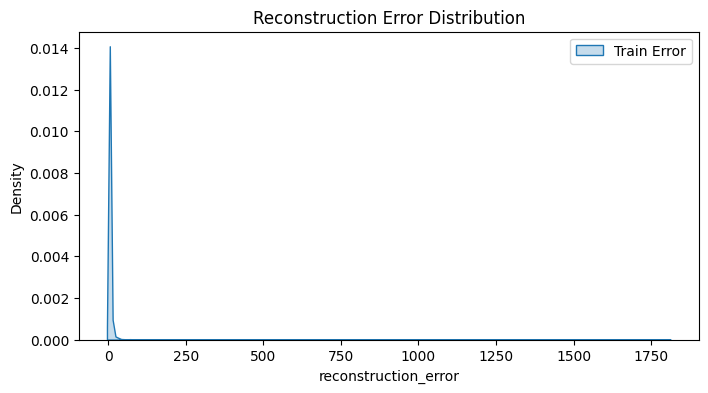

In [69]:
plt.figure(figsize=(8, 4))
sns.kdeplot(reconstruction_error, label="Train Error", shade=True)
plt.title("Reconstruction Error Distribution")
plt.legend()
plt.show()
